In [1]:
# Load required libraries
library(tidyverse)
library(janitor)
library(dplyr)
library(ggplot2)
library(skimr)
library(purrr)
library(lubridate)

# Source helper scripts
source("../../R/apply_factors.R")
source("../../R/analysis_helpers.R")
source("../../R/temporal_helpers.R")

# Load data
tables <- list(
  Orders  = readr::read_csv("../../data/processed/Orders.csv"),
  Returns = readr::read_csv("../../data/processed/Returns.csv"),
  People  = readr::read_csv("../../data/processed/People.csv")
)

# Apply factor transformations
tables <- apply_factors(tables)

# Extract tables
orders  <- tables$Orders
returns <- tables$Returns
people  <- tables$People

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Rows: 51290 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): order_id, ship_mode, customer_name, segment, state, country, mark...
dbl   (6): sales, quantity, discount, profit, shipping_cost, year
date  (2): order_date, ship_date

ℹ Use `spec()` to retrieve the full column specification f

# Are sales statistically significant predictors of profit?

## Linear Regression

We estimate:

$profit_i = \beta_0 + \beta_1,sales_i + \varepsilon_i$

* $\beta_0$: baseline profit when $sales_i = 0$
* $\beta_1$: expected change in profit for a $1 increase in sales
* $\varepsilon_i$: unexplained variation across orders

Test: $H_0:\beta_1=0$ (sales has no association with profit).

In [2]:
# Linear relationship: profit ~ sales
profit_sales_lm <- lm(profit ~ sales, data = orders)
summary(profit_sales_lm)


Call:
lm(formula = profit ~ sales, data = orders)

Residuals:
    Min      1Q  Median      3Q     Max 
-7368.1    -3.9    13.9    24.5  5372.0 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -14.208783   0.754269  -18.84   <2e-16 ***
sales         0.173842   0.001381  125.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 152.4 on 51288 degrees of freedom
Multiple R-squared:  0.2361,	Adjusted R-squared:  0.2361 
F-statistic: 1.585e+04 on 1 and 51288 DF,  p-value: < 2.2e-16


## Sales vs Profit (Log–Log)

To capture proportional effects and reduce skewness:

$\log(1+profit_i) = \beta_0 + \beta_1,\log(1+sales_i) + \varepsilon_i$

* $\beta_1$ (elasticity-style): a 1% increase in sales is associated with an approximate $\beta_1$% change in profit (for positive-profit observations).
* orders with $profit \le 0$ are dropped by the log transform.

In [4]:
profit_sales_log_lm <- lm(  log1p(profit) ~ log1p(sales),  data = orders)
summary(profit_sales_log_lm)

Warning message in log1p(profit):
“NaNs produced”



Call:
lm(formula = log1p(profit) ~ log1p(sales), data = orders)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.0591 -0.3903  0.2815  0.6325  1.6085 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.968404   0.016080  -60.22   <2e-16 ***
log1p(sales)  0.859369   0.003351  256.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9267 on 39260 degrees of freedom
  (12028 observations deleted due to missingness)
Multiple R-squared:  0.6261,	Adjusted R-squared:  0.6261 
F-statistic: 6.575e+04 on 1 and 39260 DF,  p-value: < 2.2e-16


#  Does the Probability of Loss Change with Sales Size?

## Probability of Loss vs Sales (Logistic)

Define:

$loss_i = \mathbb{1}[profit_i < 0]$

Model:

$\Pr(loss_i=1 \mid sales_i) = \text{logit}^{-1}(\beta_0 + \beta_1,sales_i)$

* $\beta_1 < 0$: higher sales → lower probability of a loss
* $\exp(\beta_1)$: multiplicative change in the odds of loss for a $1 increase in sales

In [5]:
orders <- orders |>
    mutate(loss = as.integer(profit < 0))
loss_sales_logit <- glm(
    loss ~ sales,
    data = orders,
    family = binomial(link = "logit")
)
summary(loss_sales_logit)


Call:
glm(formula = loss ~ sales, family = binomial(link = "logit"), 
    data = orders)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.044e+00  1.187e-02  -87.96   <2e-16 ***
sales       -3.695e-04  2.858e-05  -12.93   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 57062  on 51289  degrees of freedom
Residual deviance: 56861  on 51288  degrees of freedom
AIC: 56865

Number of Fisher Scoring iterations: 4


## Probability of Loss vs Log Sales (Logistic)

$\Pr(loss_i=1 \mid sales_i) = \text{logit}^{-1}(\beta_0 + \beta_1,\log(1+sales_i))$

* $\beta_1$: effect of a proportional increase in sales on loss probability
* Often fits better when scale effects are nonlinear (check AIC).

In [6]:
loss_sales_log_logit <- glm(
    loss ~ log1p(sales),
    data = orders,
    family = binomial(link = "logit")
)
summary(loss_sales_log_logit)


Call:
glm(formula = loss ~ log1p(sales), family = binomial(link = "logit"), 
    data = orders)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.302948   0.033694  -8.991   <2e-16 ***
log1p(sales) -0.186819   0.007421 -25.174   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 57062  on 51289  degrees of freedom
Residual deviance: 56412  on 51288  degrees of freedom
AIC: 56416

Number of Fisher Scoring iterations: 4


Data were 'prettified'. Consider using `terms="sales [all]"` to get
  smooth plots.



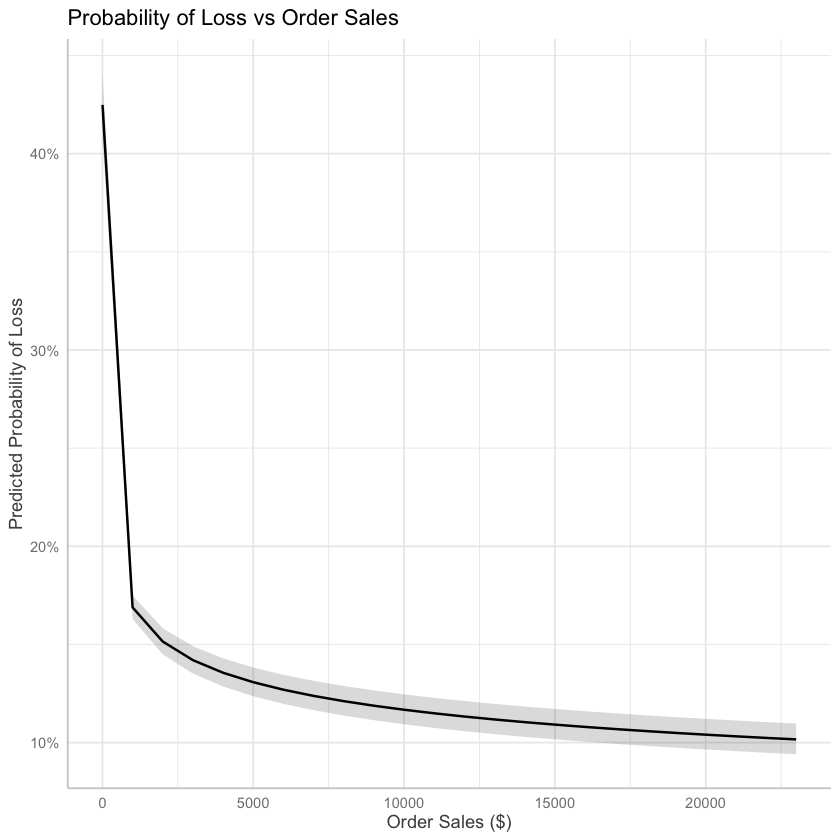

In [8]:
library(ggeffects)
pred_loss <- ggpredict(loss_sales_log_logit, terms = "sales")
plot(pred_loss) +  labs(
    x = "Order Sales ($)",
    y = "Predicted Probability of Loss",
    title = "Probability of Loss vs Order Sales"
)

# What order characteristics can be good predictors to profit?

To identify which factors explain order-level profit, we estimate a multiple linear regression model with profit as the response variable.

### Model

$$
Profit_i =
\beta_0
+ \beta_1 Discount_i
+ \beta_2 Quantity_i
+ Category_i
+ Priority_i
+ \varepsilon_i
$$


The coefficients measure **marginal effects** on profit while holding all other variables constant.

### Inference

The model is estimated via ordinary least squares (OLS). Statistical significance is assessed using t-tests for individual predictors and F-tests for categorical effects. To compare relative importance across variables measured on different scales, standardized coefficients are also examined.


In [9]:
profit_model <- lm(
    profit ~ discount + quantity + order_priority + category,  data = orders)
summary(profit_model)


Call:
lm(formula = profit ~ discount + quantity + order_priority + 
    category, data = orders)

Residuals:
    Min      1Q  Median      3Q     Max 
-6526.8   -43.0   -22.9    24.2  8287.2 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               45.4355     2.2496  20.197   <2e-16 ***
discount                -258.8607     3.4072 -75.975   <2e-16 ***
quantity                   7.5067     0.3169  23.688   <2e-16 ***
order_priority.L           3.7766     2.8553   1.323   0.1860    
order_priority.Q          -0.3563     2.2616  -0.158   0.8748    
order_priority.C           2.9906     1.4407   2.076   0.0379 *  
categoryOffice Supplies  -19.7986     1.8902 -10.474   <2e-16 ***
categoryTechnology        28.4742     2.3141  12.304   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 163.5 on 51282 degrees of freedom
Multiple R-squared:  0.1216,	Adjusted R-squared:  0.1215 
F-statistic:  

In [11]:
library(lm.beta)

profit_model_std <- lm.beta(profit_model)
summary(profit_model_std)


Call:
lm(formula = profit ~ discount + quantity + order_priority + 
    category, data = orders)

Residuals:
    Min      1Q  Median      3Q     Max 
-6526.8   -43.0   -22.9    24.2  8287.2 

Coefficients:
                          Estimate Standardized Std. Error t value Pr(>|t|)    
(Intercept)              4.544e+01           NA  2.250e+00  20.197   <2e-16 ***
discount                -2.589e+02   -3.150e-01  3.407e+00 -75.975   <2e-16 ***
quantity                 7.507e+00    9.807e-02  3.169e-01  23.688   <2e-16 ***
order_priority.L         3.777e+00    6.774e-03  2.855e+00   1.323   0.1860    
order_priority.Q        -3.563e-01   -6.730e-04  2.262e+00  -0.158   0.8748    
order_priority.C         2.991e+00    1.036e-02  1.441e+00   2.076   0.0379 *  
categoryOffice Supplies -1.980e+01   -5.537e-02  1.890e+00 -10.474   <2e-16 ***
categoryTechnology       2.847e+01    6.502e-02  2.314e+00  12.304   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Resid